Notebook to test causal SHAP on sample from first paper.

In [1]:
import sys, os
import numpy as np
import pandas as pd
from sklearn import metrics
import xgboost
import shap
import time


# as jupyter notebook cannot find __file__, import module and submodule path via current_folder
current_folder = globals()['_dh'][0]

PROJECT_SRC_PATH = os.path.realpath(os.path.join(current_folder, '..', '..', 'xml4uf'))
sys.path.append(PROJECT_SRC_PATH)

from ufo_map.Utils.helpers import *

/opt/anaconda3/envs/urban_form_local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prep_data(df,list_features,cutoff=10,split=0.8):
    # drop Nans
    df = df.dropna()
    # shave of statistically insignificant rows 
    df = df.loc[df["points_in_hex"] > cutoff]
    df = df.reset_index(drop=True)

    # split data
    df_train = df.sample(frac=split,random_state=0)
    df_test = df.drop(df_train.index) 

    # assign to X_train and X_test
    X_train = df_train[[col for col in df_train.columns if col in list_features]]
    #X_train["feature_noise"] = np.random.normal(size=len(df_train))
    X_test = df_test[[col for col in df_test.columns if col in list_features]]
    #X_test["feature_noise"] = np.random.normal(size=len(df_test))

    # assign target to y
    y_train_nc = df_train[target]
    y_test_nc = df_test[target]

    # centering y (?!)
    y_train = y_train_nc.subtract(y_train_nc.mean())
    y_test = y_test_nc.subtract(y_test_nc.mean())

    # create results df
    df_test = df_test[['tripdistancemeters','hex_id']]
    df_test.rename(columns={'tripdistancemeters':'y_test'},inplace=True) 

    print('X_train: {}'.format(X_train.shape))
    print('y_train: {}'.format(y_train.shape))
    print('X_test: {}'.format(X_test.shape))
    print('y_test: {}'.format(y_test.shape))
    print('Train-Split: {} %'.format(round((len(df_train)/len(df)), 2)))
    return X_train,X_test,y_train,y_test,df_train,df_test

In [3]:
def train_model(X_train,X_test,y_train,y_test,df_test):
    print('...fitting tree...')
    # train model
    tree = xgboost.XGBRegressor()
    model = tree.fit(X_train, y_train)
    y_predict = tree.predict(X_test)

    # Append results to df_results
    df_test['y_predict_trees'] = y_predict
    df_test['error_trees'] = df_test ['y_predict_trees'] - df_test ['y_test']
    df_test['error_abs_trees'] = abs(df_test['error_trees'])

    # Metric of model
    r2_model = tree.score(X_train,y_train)
    # Metrics of prediction
    r2_pred = tree.score(X_test,y_test)
    mae_pred = metrics.mean_absolute_error(df_test['y_test'],df_test['y_predict_trees'])
    rmse_pred = np.sqrt(metrics.mean_squared_error(df_test['y_test'],df_test['y_predict_trees']))

    #Plot metrics each round!
    print('Metrics of prediction')
    print('R2 Model: {}'.format(r2_model))
    print('R2 Predict: {}'.format(r2_pred))
    print('MAE: {} m'.format(mae_pred))
    print('RMSE: {} m'.format(rmse_pred))        
    return model, df_test


### run functions

In [4]:
df = pd.read_csv('/Users/Felix/Documents/Studium/PhD/05_Projects/03_Understand_Urban_Form_on_Mobility/03_Program/data/run_21.07.05/out/21.08.21_shap/run10_5_xgb_2k_orig_hex_8_kepler_v2.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,hex_id,tripdistancemeters,lengthoftrip,points_in_hex,feature_distance_cbd,feature_distance_local_cbd,feature_pop_density,feature_transit_density,...,feature_beta_index,lng,lat,shap_values_ft1,shap_data_ft1,shap_values_ft2,shap_data_ft2,shap_values_ft3,shap_data_ft3,shap_in_out
0,0,0,881f18b4ebfffff,20547.626902,1779.514929,553.0,27297.324079,12944.144079,205.0,6.0,...,2.818182,13.728477,52.428823,7215.4870,27297.324079,2515.7920,12944.144079,177.29778,1.811433,1
1,1,1,881f18b4c5fffff,14886.706346,1519.628029,171.0,26845.384537,12492.204537,17.0,4.0,...,2.363636,13.725423,52.436051,4367.8926,26845.384537,2387.4988,12492.204537,153.20953,1.811433,1
2,2,2,881f18b5edfffff,16900.834889,1648.130054,1096.0,22835.857395,9368.157395,1448.0,4.0,...,3.076923,13.637655,52.386462,3492.1180,22835.857395,1724.7839,9368.157395,288.50937,1.662552,1
3,3,3,881f18b517fffff,17207.823467,1711.628796,686.0,22422.666379,8954.966379,1448.0,8.0,...,3.148148,13.634594,52.393692,3450.2693,22422.666379,1769.9951,8954.966379,291.24292,1.662552,1
4,4,4,881f18b563fffff,14369.969879,1591.098605,752.0,19741.392686,7420.970686,1353.0,11.0,...,3.322581,13.573637,52.395022,2651.9810,19741.392686,742.7942,7420.970686,663.58167,1.059678,1


In [5]:
# general varibales
cutoff = 10
target = 'tripdistancemeters'
# define features
used_features = ['feature_distance_cbd',
 'feature_distance_local_cbd',
 'feature_pop_density',
 'feature_ua_Industrial, commercial area',
 'feature_income']

In [6]:
# prep data
X_train,X_test,y_train,y_test,df_train,df_test = prep_data(df,used_features)
# train model
model, df_test = train_model(X_train,X_test,y_train,y_test,df_test)

X_train: (674, 5)
y_train: (674,)
X_test: (168, 5)
y_test: (168,)
Train-Split: 0.8 %
...fitting tree...
Metrics of prediction
R2 Model: 0.9996062460530996
R2 Predict: 0.7380904165469822
MAE: 9747.289167460742 m
RMSE: 9823.361309736894 m


## NORMAL FEATURE IMPORTANCE SHAP

In [7]:
# calculate feature importances
feature_importance = model.feature_importances_
feature_importance

array([0.52662426, 0.20048918, 0.05848804, 0.06836768, 0.14603081],
      dtype=float32)

In [8]:
# calculate shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


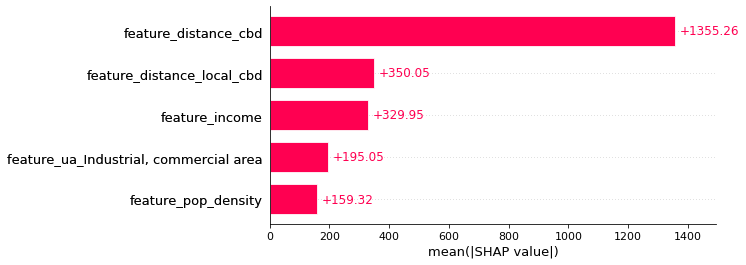

In [9]:
shap.plots.bar(shap_values, show=False)

# Now lets try with CAUSAL SHAP EXPLAINER

In [10]:
sys.path.append('/Users/Felix/code/causal_shap_python')
from explainer import Explainer

In [11]:
explainer_symmetric = Explainer(X_train, model)
p = y_train.mean()

In [12]:
# assumption: 
# 1. distance to cbd influences distance to local cbd
# 2. distance to cbd and (to a minor extend) distance to local cbd influence other variabkes
# 3. 3 other variables are also not completely independent of another - potentially confounder?! - maybe yes maybe not
partial_order = [[0],[1],[2,3,4]]

confounding = [False, False, False]


In [13]:
start = time.perf_counter()
explanation_causal = explainer_symmetric.explain_causal(X_test,
                                                        p,
                                                        ordering=partial_order,
                                                        confounding=confounding,
                                                        seed=2)
stop = time.perf_counter()
print("explain_causal time : "+str(stop-start))



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


explain_causal time : 38.15861058799999


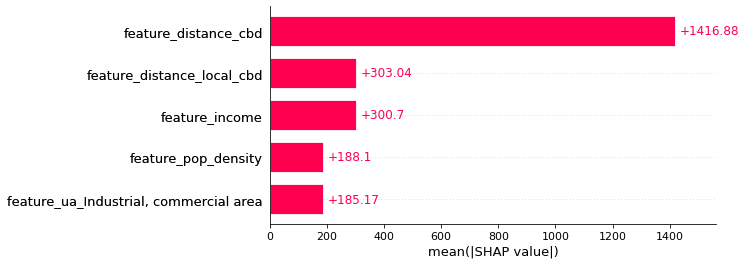

In [14]:
shap.plots.bar(explanation_causal)

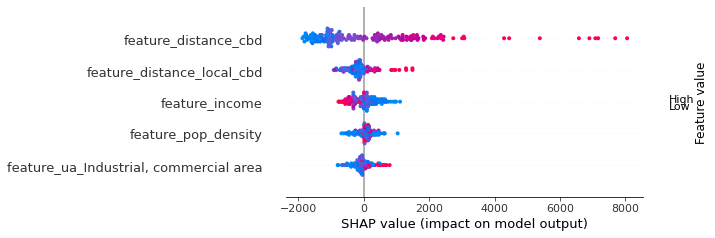

In [16]:
# summaryy plot with casual shap
shap.summary_plot(explanation_causal)

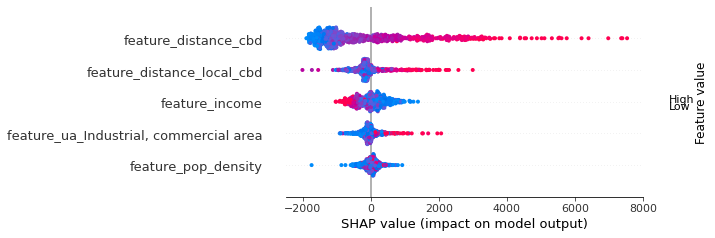

In [17]:
# summary plot of normally calculated features
shap.summary_plot(shap_values)